In [1]:
import copy
from collections import defaultdict
from itertools import product
from pathlib import Path
from typing import Callable, List, Dict, Tuple, Union, Any

from bella import lexicons
from bella.tokenisers import ark_twokenize
from bella.dependency_parsers import tweebo
from bella import parsers
from bella.data_types import TargetCollection
from bella.word_vectors import VoVectors, SSWE
from bella.models.tdparse import TDParseMinus, TDParse, TDParsePlus
from bella.models.base import SKLearnModel
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
from sklearn.metrics import accuracy_score, f1_score
import pandas as pd
import seaborn as sns
from textwrap import wrap

import config
import thesis_statistics as thesis_stats


matplotlib.rc('font', size=14)
matplotlib.rc('axes', titlesize=14)
matplotlib.rc('axes', labelsize=14)
matplotlib.rc('legend', fontsize=10)
matplotlib.rc('xtick', labelsize=12)
matplotlib.rc('ytick', labelsize=12)
sns.set_style("whitegrid")

def all_words(tokeniser: Callable[[str], List[str]], 
              *datasets) -> List[str]:
    '''
    :returns: All unique tokens/words from the given datasets 
              using the tokeniser given.
    '''
    words = []
    for dataset in datasets:
        words.extend(dataset.word_list(tokeniser))
    words = list(set(words))
    return words

def method_predictions(train: TargetCollection, test: TargetCollection, 
                       model: SKLearnModel, save_dir: Path,
                       save_name_addon: str = '') -> np.ndarray:
    '''
    Given a training and test dataset, it will run train the model and 
    make predictions on the test datasets, of wich those results will be 
    saved. The results from the test predictions will be returned. 
    If the results already exist the model will not be re-trained 
    but rather the saved predictions will be returned (caching). 
    '''
    dataset_name = train.name.split()[0]
    save_dir = Path(save_dir, model.name())
    save_dir.mkdir(parents=True, exist_ok=True)
    if save_name_addon != '':
        save_file = Path(save_dir, f'Reproduction {save_name_addon} {dataset_name}.npy')
    else:
        save_file = Path(save_dir, f'Reproduction {dataset_name}.npy')
    if save_file.exists():
        return np.load(save_file)
    
    X_train = train.data_dict()
    X_test = test.data_dict()
    y_train = train.sentiment_data()
    
    model.fit(X_train, y_train)
    raw_predictions = model.predict(X_test)
    np.save(save_file, raw_predictions)
    return raw_predictions

def feature_predictions(x_train: np.ndarray, y_train: np.ndarray, 
                        x_test: np.ndarray, 
                        dataset_name: str, model_name: str, 
                        model: SKLearnModel, save_dir: Path,
                        fold_number: int = None
                        ) -> np.ndarray:
    '''
    Compared to `predictions` this allows more flexiability in 
    where to save the data too. This is mainly used when 
    performing cross validation.
    '''
    save_dir.mkdir(parents=True, exist_ok=True)
    save_file = Path(save_dir, f'{dataset_name} {model_name}.npy')
    if fold_number is not None:
        save_file = Path(save_dir, f'{dataset_name} fold {fold_number} {model_name}.npy')
    if save_file.exists():
        return np.load(save_file)
    model.fit(x_train, y_train)
    raw_predictions = model.predict(x_test)
    np.save(save_file, raw_predictions)
    return raw_predictions

def multi_metric_df(p_values: Dict[str, pd.DataFrame]) -> pd.DataFrame:
    '''
    Creates a DataFrame whereby the dataframes in the values of the 
    given dictionary are concatenated together column wise. The 
    key values in the given dictionary are used to create the top 
    level column index. 
    '''
    p_values_temp = copy.deepcopy(p_values)
    all_p_values = []
    for metric_name, p_value in p_values_temp.items():
        columns = p_value.columns
        new_columns = list(product([metric_name], columns))
        p_value.columns = pd.MultiIndex.from_tuples(new_columns)
        all_p_values.append(p_value)
    return pd.concat(all_p_values, 1)

def plot_score_confidences(scores: np.ndarray, confidences: np.ndarray,
                           x_values: List[Union[str, int, float]], 
                           ax: matplotlib.axes,
                           x_label: str, y_label: str, title: str = '',
                           **plot_kwargs) -> 'matplotlib.axes.Axes':
    '''
    Given point estimate(s) and the confidence range(s) will plot the estimates
    and confidences as an error bar plot.

    :param scores: Vector of point estimate(s), shape = [n]
    :param confidences: Vector of confidence range(s), shape = []
    :param x_values: List of values to put on the X axis e.g. names of the
                     models that created the point estimates.
    :param ax: A Matplotlib axes to draw with.
    :param x_label: Label to assign to the X axis.
    :param y_label: Label to assign to the Y axis.
    :param title: Title of the plot. Optional if '' given then no title.
    :param **plot_kwargs: Keyword arguments to the
                          :py:func:`matplotlib.axes.Axes.errorbar`
    :return: The matplotlib axes that stores the plot information as an error
             bar plot.
    '''
    num_scores = scores.shape[0]
    scores = scores.reshape((num_scores, 1))
    yerrs = np.abs((scores - confidences).T)
    for i, x in enumerate(x_values):
        yerr = yerrs[:, i].reshape((2, 1))
        if i!=0 and 'label' in plot_kwargs:
            plot_kwargs.pop('label')
        ax.errorbar([x_values[i]], scores[i], yerr=yerr,
                    fmt="bo", capsize=5, zorder=i, **plot_kwargs)
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    if title:
        ax.set_title(title)
    return ax

def plot_model_metrics(y_test: np.ndarray, preds: np.ndarray, 
                       metric: Callable[[np.ndarray, np.ndarray], float], 
                       **metric_kwargs) -> np.ndarray:
    model_metric = [metric(y_test, pred, **metric_kwargs) for pred in preds]
    return np.array(model_metric) * 100

def confidence_plots(predictions: np.ndarray, boot_predictions: List[np.ndarray], 
                     y_test: np.ndarray, 
                     metrics: List[Callable[[np.ndarray, np.ndarray], float]], 
                     metrics_kwargs: List[Union[None, Dict[str, Any]]],
                     metric_names: List[str], model_names: List[str],
                     original_scores: List[float], dataset_name: str,
                     model_group_name: str,
                     figsize: Tuple[int, int] = (15, 7)):
    
    number_metrics = len(metric_names)
    fig, axs = plt.subplots(1, number_metrics, figsize=figsize)
    model_names = ['\n'.join(wrap(name, 15)) 
                   for name in model_names]
    
    for metric_index, boot_prediction in enumerate(boot_predictions):
        metric_name = metric_names[metric_index]
        confidence_ranges = [thesis_stats.confidence_range(boot_preds, 0.05, 'two') 
                             for boot_preds in boot_prediction.T]
        confidence_ranges = np.array(confidence_ranges) * 100
        
        metric_func = metrics[metric_index]
        metric_kwargs = metrics_kwargs[metric_index]
        if metric_kwargs:
            model_score = plot_model_metrics(y_test, predictions.T, 
                                        metric_func, **metric_kwargs)
        else:
            model_score = plot_model_metrics(y_test, predictions.T, metric_func)
            
        plot_ax = axs[metric_index]
        #plot_title = f'{model_group_name} Models {metric_name} on\n{dataset_name} Test Data'
        plot_title = ''
        plot_ax = plot_score_confidences(model_score, 
                                         confidence_ranges, 
                                         model_names, plot_ax,
                                         'Models', f'{metric_name} (%)',
                                         plot_title,
                                         label='Reproduced')
        plot_ax.plot(model_names, original_scores[metric_index], 'r^', label='Original')
        plot_ax.legend()
    return plot_ax

def mean_std(data: pd.Series) -> str:
   to_percentage = data * 100
   return f'{np.mean(to_percentage):.2f} ({np.std(to_percentage):.2f})'

Using TensorFlow backend.


# Reproduction of [Wang et al. 2017](https://www.aclweb.org/anthology/E17-1046.pdf) TDParse models

In this notebook we explore the different neural pooling models that [Wang et al. 2017](https://www.aclweb.org/anthology/E17-1046.pdf) created for Target Dependent Sentiment Analysis (TDSA). This approach is a direct extension of [Vo et al. 2015](https://ijcai.org/Proceedings/15/Papers/194.pdf), whereby the main difference is that the context windows utilise the depedency structure created from a dependency parser (in this case the [Tweebo Parser](https://www.aclweb.org/anthology/D14-1108.pdf)). Each of the three methods use different context windows of the text that the target occured in but applied the same 5 neural pooling functions (max, min, average, standard deviation, and product). The three different target methods explored from the paper are the following:

1. TDParse Minus -- Only used the dependency context.
2. TDParse -- Left, right, target, and dependency contexts.
3. TDParse Plus -- Left, right, target, dependency, *LS*, and *RS* contexts.

In all of the experiments we use the same word vectors which are the concatenation of the Twitter Word2Vec embeddings (100 dimension embeddings) from their paper and the Sentiment Specific Word Embeddings (SSWE) (50 dimension embeddings) from [Tang et al. 2014](https://www.aclweb.org/anthology/P14-1146.pdf). We also use the same TitterNLP tokenizer ([Gimpel et al. 2011](https://www.cs.cmu.edu/~ark/TweetNLP/gimpel+etal.acl11.pdf)) (in the Bella package it is called `ark_twokenize`).

## Load the data, embeddings, and sentiment lexicons.

First we load the data that [Wang et al. 2017](https://www.aclweb.org/anthology/E17-1046.pdf) evaluated on, which was the Twitter dataset from [Dong et al. 2014](https://www.aclweb.org/anthology/P14-2009.pdf) and their on Election Twitter dataset. We then load the word embeddings used. Finally load the sentiment lexicons that are used in the TDParse Plus method. 

The sentiment lexicons used are the following three combined:

1. MPQA [Wilson et al. 2005](https://www.aclweb.org/anthology/H05-1044/).
2. NRC [Mohammad and Turney 2010](https://www.aclweb.org/anthology/W10-0204/).
3. HL [Hu and Liu 2004](https://www.cs.uic.edu/~liub/publications/kdd04-revSummary.pdf)

In [2]:
# Load the datasets
dong_train = parsers.dong(config.DONG_TRAIN, name='Dong Train')
dong_test = parsers.dong(config.DONG_TEST, name='Dong Test')

election_train = parsers.election_train(config.ELECTION, name='Election Train')
election_test = parsers.election_test(config.ELECTION, name='Election Test')

# Find all the words/tokens in the datasets so that we can reduce 
# the word vectors so that they only contain relevant words
dong_words = all_words(ark_twokenize, dong_train, dong_test)
election_words = all_words(ark_twokenize, election_train, election_test)
election_words = [word.lower() for word in election_words]
# Loading the embeddings
# Word Vectors filtered by the dataset words
sswe_dong = SSWE(filter_words=dong_words)
w2v_dong = VoVectors(filter_words=dong_words)

sswe_election = SSWE(filter_words=election_words)
w2v_election = VoVectors(filter_words=election_words)


# Load the sentiment lexicons so that they only use words that come from 
# the following two semantic categories: 1. Positive and 2. Negative
subset_cats = {'positive', 'negative'}
mpqa = lexicons.Mpqa(config.MPQA, 
                     subset_cats=subset_cats, lower=True)
hu_liu = lexicons.HuLiu(config.HL, 
                        subset_cats=subset_cats, lower=True)
nrc = lexicons.NRC(config.NRC, subset_cats=subset_cats, lower=True)
# Combining the lexicons together
mpqa_huliu = lexicons.Lexicon.combine_lexicons(mpqa, hu_liu)
all_lexicons = lexicons.Lexicon.combine_lexicons(mpqa_huliu, nrc)

## Experiments

We show below that the 

The C-Values for these models were found through 5 fold cross validation, whereby each model found it's optimal C value for each dataset. The range of C-values tested were:

$$C=\{ 2^n | n = (i \times 2) - 17 ~for~0 < i < 10~and~i \in \mathbb{Z} \} \cup \{ 1 \} $$

Of which for Dong and Election datasets this found the following optimal C-Values:

| Model          | Dong C-Value   |  Election C-Value   |
| -------------- | -------------- | ------------------- |
| TDParse Minus  |  $2^{-5}$       |   $2^{-7}$         |
| TDParse        |  $2^{-7}$     |   $2^{-9}$       |
| TDParse Plus   |  $2^{-7}$     |   $2^{-9}$       |

These C-Values were found using from the following [notebook](https://github.com/apmoore1/Bella/blob/master/notebooks/TDParse.ipynb), whereby these are optimised for the accuracy metric.

The experiment below is conducted on the Election and Dong Twitter dataset using MinMax scaling where the scale range is between 0 and 1:

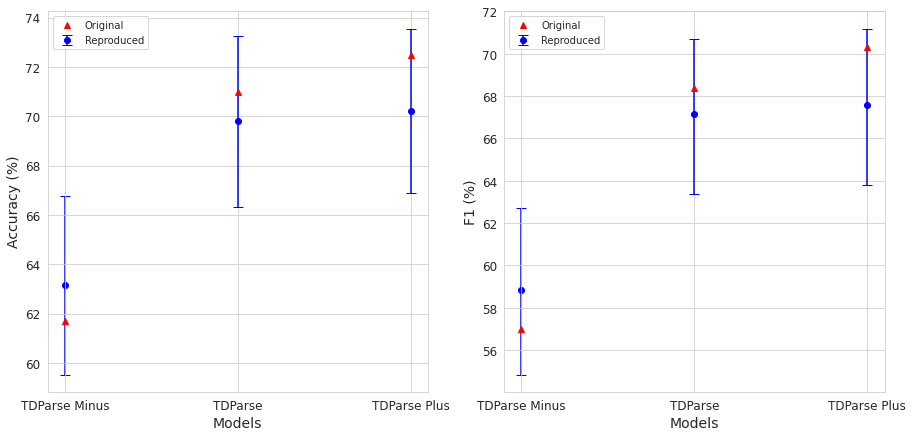

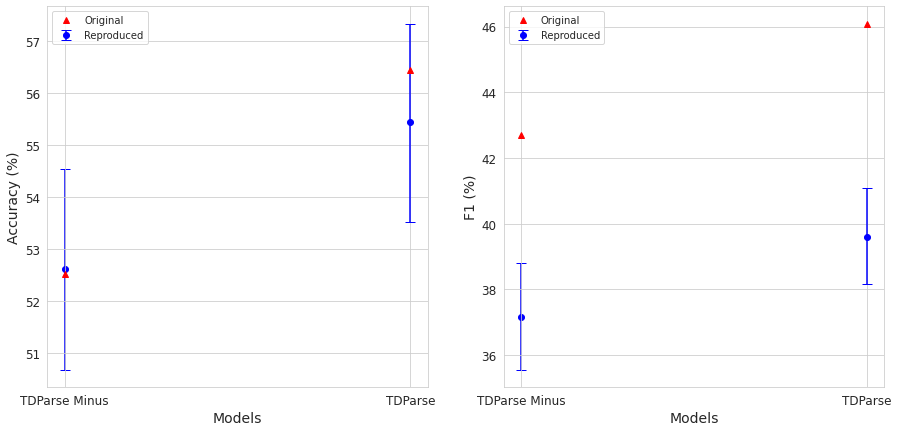

In [6]:
results_dir = config.RESULTS_DIR
image_dir = config.IMAGES_DIR / 'Reproduction'
image_dir.mkdir(exist_ok=True, parents=True)
# Run the Target models
c_values  = {'Dong': {'TDParse Minus': 0.03125,
                      'TDParse': 0.0078125,
                      'TDParsePlus': 0.0078125}, 
             'Election': {'TDParse Minus': 0.0078125,
                          'TDParse': 0.001953125,
                          'TDParsePlus': 0.001953125}}
word_vectors = {'Dong': [w2v_dong, sswe_dong], 
                'Election': [w2v_election, sswe_election]}
train_test_dataset = {'Dong': [dong_train, dong_test], 
                      'Election': [election_train, election_test]}
results = {}
orginial_scores = {'Dong': [[61.7, 71.0, 72.5], [57.0, 68.4, 70.3]],
                   'Election': [[52.53, 56.45], [42.71, 46.09]]}

for dataset in ['Dong', 'Election']:
    train, test = train_test_dataset[dataset]
    vectors = word_vectors[dataset]
    dataset_c = c_values[dataset]
    tdparse_minus = TDParseMinus(vectors, tweebo,
                                 C=dataset_c['TDParse Minus'])
    tdparse = TDParse(vectors, tweebo,
                      C=dataset_c['TDParse'])
    tdparse_plus = TDParsePlus(vectors, tweebo,
                               C=dataset_c['TDParsePlus'],
                               senti_lexicon=all_lexicons)
    models = [tdparse_minus, tdparse, tdparse_plus]
    model_names = ['TDParse Minus', 'TDParse', 'TDParse Plus']
    dataset_preds = []
    for model in models:
        preds = method_predictions(train, test, model, results_dir)
        preds = np.expand_dims(np.array(preds), 1)
        dataset_preds.append(preds)
    dataset_preds = np.concatenate(dataset_preds, 1)
    results[dataset] = dataset_preds
    if dataset == 'Election':
        dataset_preds = dataset_preds[:,:2]
        model_names = model_names[:2]

    test_y = np.array(test.sentiment_data())
    bootstrap_acc_preds = thesis_stats.bootstrap(test_y, dataset_preds, 
                                                 accuracy_score, n=10000)
    bootstrap_f1_preds = thesis_stats.bootstrap(test_y, dataset_preds, f1_score, 
                                                average='macro', n=10000)
    boot_preds = [bootstrap_acc_preds, bootstrap_f1_preds]
    metric_funcs = [accuracy_score, f1_score]
    metrics_kwargs = [None, {'average': 'macro'}]
    metric_names = ['Accuracy', 'F1']
    dataset_orginial_scores = orginial_scores[dataset]
    ax = confidence_plots(dataset_preds, boot_preds, test_y, 
                          metric_funcs, metrics_kwargs, metric_names, 
                          model_names, dataset_orginial_scores, dataset, 'TDParse')
    image_fp = str(Path(image_dir, f'TDParse_{dataset}.pdf').resolve())
    ax.figure.savefig(image_fp, bbox_inches='tight')

The experiment below is conducted on the Election and Dong Twitter dataset with no scaling:

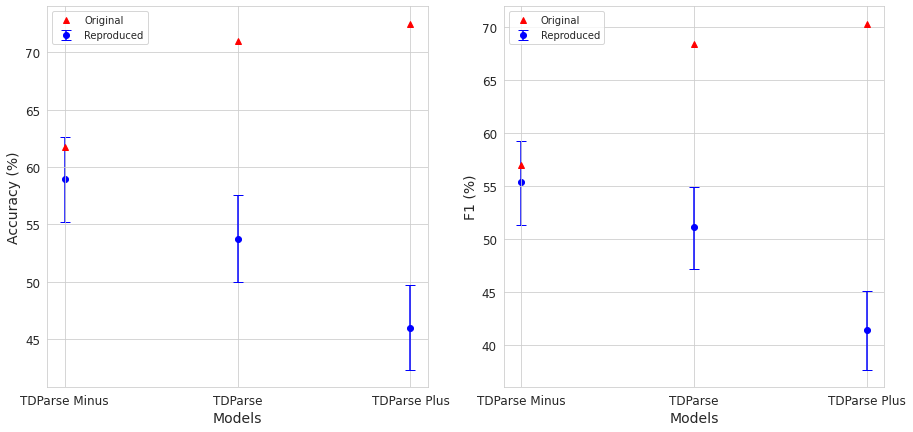

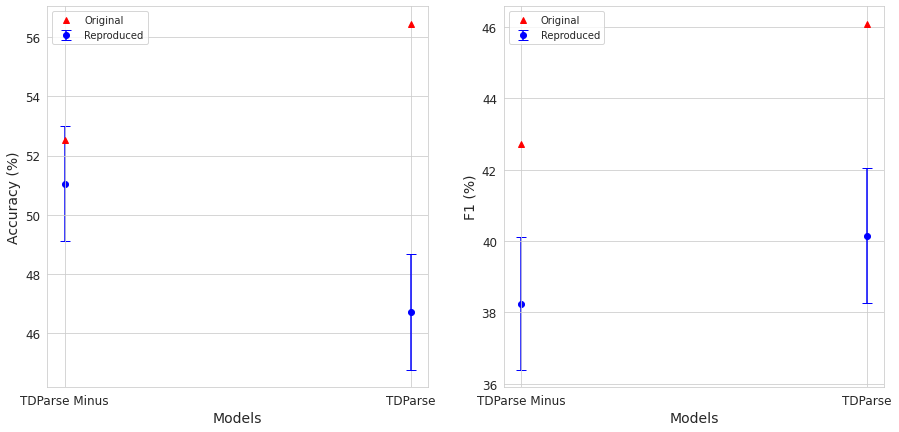

In [7]:
results_no_scale = {}

for dataset in ['Dong', 'Election']:
    train, test = train_test_dataset[dataset]
    vectors = word_vectors[dataset]
    dataset_c = c_values[dataset]
    tdparse_minus = TDParseMinus(vectors, tweebo, scale=None,
                                 C=dataset_c['TDParse Minus'])
    tdparse = TDParse(vectors, tweebo, scale=None,
                      C=dataset_c['TDParse'])
    tdparse_plus = TDParsePlus(vectors, tweebo, scale=None,
                               C=dataset_c['TDParsePlus'],
                               senti_lexicon=all_lexicons)
    models = [tdparse_minus, tdparse, tdparse_plus]
    model_names = ['TDParse Minus', 'TDParse', 'TDParse Plus']
    dataset_preds = []
    for model in models:
        preds = method_predictions(train, test, model, results_dir,
                                   save_name_addon='No Scale')
        preds = np.expand_dims(np.array(preds), 1)
        dataset_preds.append(preds)
    dataset_preds = np.concatenate(dataset_preds, 1)
    results_no_scale[dataset] = dataset_preds
    
    if dataset == 'Election':
        dataset_preds = dataset_preds[:,:2]
        model_names = model_names[:2]

    test_y = np.array(test.sentiment_data())
    bootstrap_acc_preds = thesis_stats.bootstrap(test_y, dataset_preds, 
                                                 accuracy_score, n=10000)
    bootstrap_f1_preds = thesis_stats.bootstrap(test_y, dataset_preds, f1_score, 
                                                average='macro', n=10000)
    boot_preds = [bootstrap_acc_preds, bootstrap_f1_preds]
    metric_funcs = [accuracy_score, f1_score]
    metrics_kwargs = [None, {'average': 'macro'}]
    metric_names = ['Accuracy', 'F1']
    dataset_orginial_scores = orginial_scores[dataset]
    ax = confidence_plots(dataset_preds, boot_preds, test_y, 
                          metric_funcs, metrics_kwargs, metric_names, 
                          model_names, dataset_orginial_scores, dataset, 'TDParse')
    image_fp = str(Path(image_dir, f'TDParse_no_scale_{dataset}.pdf').resolve())
    ax.figure.savefig(image_fp, bbox_inches='tight')

The experiment below is conducted on the Election and Dong Twitter dataset with MinMax scaling, using the scaling range -1 and 1 which was originally used in [Wang et al. 2017](https://www.aclweb.org/anthology/E17-1046.pdf):

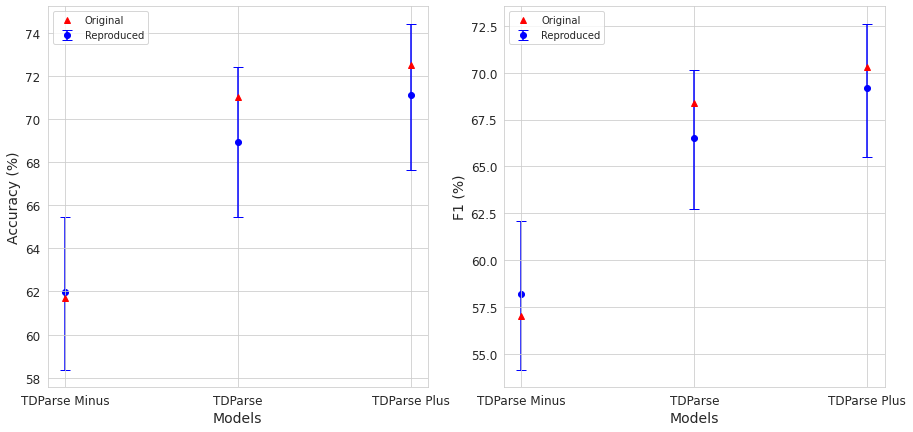

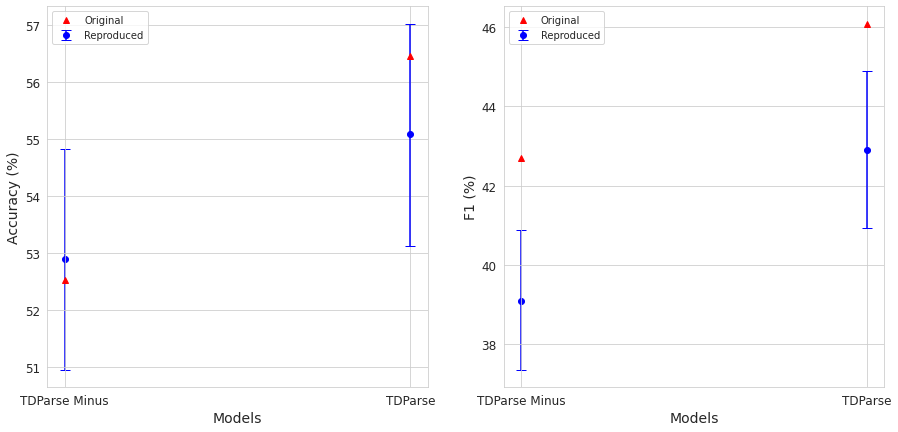

In [8]:
from sklearn.preprocessing import MinMaxScaler
results_alt_scale = {}

alt_scaler = MinMaxScaler(feature_range=(-1,1))

for dataset in ['Dong', 'Election']:
    train, test = train_test_dataset[dataset]
    vectors = word_vectors[dataset]
    dataset_c = c_values[dataset]
    tdparse_minus = TDParseMinus(vectors, tweebo, scale=alt_scaler,
                                 C=dataset_c['TDParse Minus'])
    tdparse = TDParse(vectors, tweebo, scale=alt_scaler,
                      C=dataset_c['TDParse'])
    tdparse_plus = TDParsePlus(vectors, tweebo, scale=alt_scaler,
                               C=dataset_c['TDParsePlus'],
                               senti_lexicon=all_lexicons)
    models = [tdparse_minus, tdparse, tdparse_plus]
    model_names = ['TDParse Minus', 'TDParse', 'TDParse Plus']
    dataset_preds = []
    for model in models:
        preds = method_predictions(train, test, model, results_dir,
                                   save_name_addon='Alt Scale')
        preds = np.expand_dims(np.array(preds), 1)
        dataset_preds.append(preds)
    dataset_preds = np.concatenate(dataset_preds, 1)
    results_alt_scale[dataset] = dataset_preds

    if dataset == 'Election':
        dataset_preds = dataset_preds[:,:2]
        model_names = model_names[:2]

    test_y = np.array(test.sentiment_data())
    bootstrap_acc_preds = thesis_stats.bootstrap(test_y, dataset_preds, 
                                                 accuracy_score, n=10000)
    bootstrap_f1_preds = thesis_stats.bootstrap(test_y, dataset_preds, f1_score, 
                                                average='macro', n=10000)
    boot_preds = [bootstrap_acc_preds, bootstrap_f1_preds]
    metric_funcs = [accuracy_score, f1_score]
    metrics_kwargs = [None, {'average': 'macro'}]
    metric_names = ['Accuracy', 'F1']
    dataset_orginial_scores = orginial_scores[dataset]
    ax = confidence_plots(dataset_preds, boot_preds, test_y, 
                          metric_funcs, metrics_kwargs, metric_names, 
                          model_names, dataset_orginial_scores, dataset, 'TDParse')
    image_fp = str(Path(image_dir, f'TDParse_alt_scale_{dataset}.pdf').resolve())
    ax.figure.savefig(image_fp, bbox_inches='tight')

In these experiments instead of using the C-values that have been optimised for the accuracy metric we use those that have been optimised for the macro F1 metric.

| Model          | Dong C-Value   |  Election C-Value   |
| -------------- | -------------- | ------------------- |
| TDParse Minus  |  $2^{-7}$       |   $2^{-3}$         |
| TDParse        |  $2^{-7}$     |   $2^{-7}$       |
| TDParse Plus   |  $2^{-9}$     |   $2^{-7}$       |

Using the using MinMax scaling where the scale range is between 0 and 1:

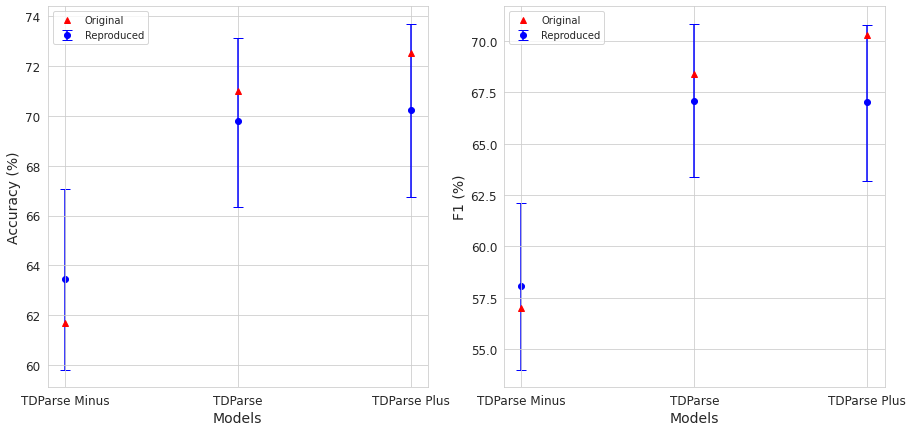

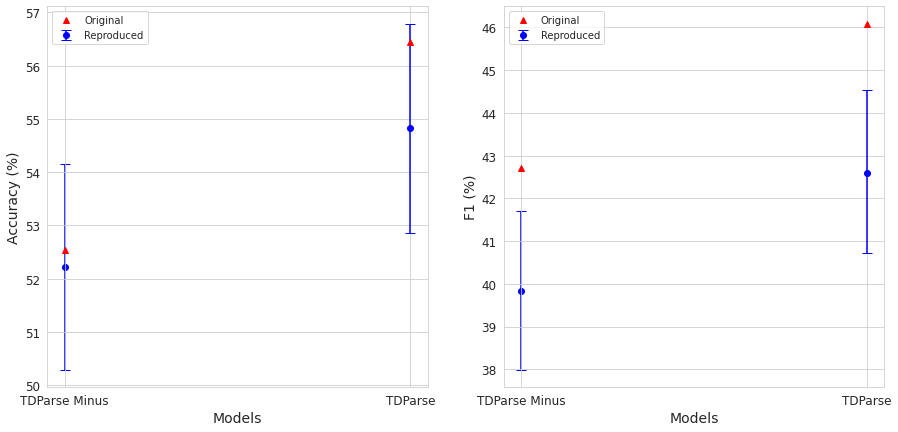

In [9]:
f1_c_values  = {'Dong': {'TDParse Minus': 0.0078125,
                         'TDParse': 0.0078125,
                         'TDParsePlus': 0.001953125}, 
                'Election': {'TDParse Minus': 0.125,
                             'TDParse': 0.0078125,
                             'TDParsePlus': 0.0078125}}
results_f1_value = {}
for dataset in ['Dong', 'Election']:
    train, test = train_test_dataset[dataset]
    vectors = word_vectors[dataset]
    dataset_c = f1_c_values[dataset]
    tdparse_minus = TDParseMinus(vectors, tweebo,
                                 C=dataset_c['TDParse Minus'])
    tdparse = TDParse(vectors, tweebo,
                      C=dataset_c['TDParse'])
    tdparse_plus = TDParsePlus(vectors, tweebo,
                               C=dataset_c['TDParsePlus'],
                               senti_lexicon=all_lexicons)
    models = [tdparse_minus, tdparse, tdparse_plus]
    model_names = ['TDParse Minus', 'TDParse', 'TDParse Plus']
    dataset_preds = []
    for model in models:
        preds = method_predictions(train, test, model, results_dir, 
                                   save_name_addon='F1 C value')
        preds = np.expand_dims(np.array(preds), 1)
        dataset_preds.append(preds)
    dataset_preds = np.concatenate(dataset_preds, 1)
    results_f1_value[dataset] = dataset_preds
    if dataset == 'Election':
        dataset_preds = dataset_preds[:,:2]
        model_names = model_names[:2]

    test_y = np.array(test.sentiment_data())
    bootstrap_acc_preds = thesis_stats.bootstrap(test_y, dataset_preds, 
                                                 accuracy_score, n=10000)
    bootstrap_f1_preds = thesis_stats.bootstrap(test_y, dataset_preds, f1_score, 
                                                average='macro', n=10000)
    boot_preds = [bootstrap_acc_preds, bootstrap_f1_preds]
    metric_funcs = [accuracy_score, f1_score]
    metrics_kwargs = [None, {'average': 'macro'}]
    metric_names = ['Accuracy', 'F1']
    dataset_orginial_scores = orginial_scores[dataset]
    ax = confidence_plots(dataset_preds, boot_preds, test_y, 
                          metric_funcs, metrics_kwargs, metric_names, 
                          model_names, dataset_orginial_scores, dataset, 'TDParse')
    image_fp = str(Path(image_dir, f'TDParse_F1_C_value_{dataset}.pdf').resolve())
    ax.figure.savefig(image_fp, bbox_inches='tight')

Using the scaling range -1 and 1 which was originally used in [Wang et al. 2017](https://www.aclweb.org/anthology/E17-1046.pdf):

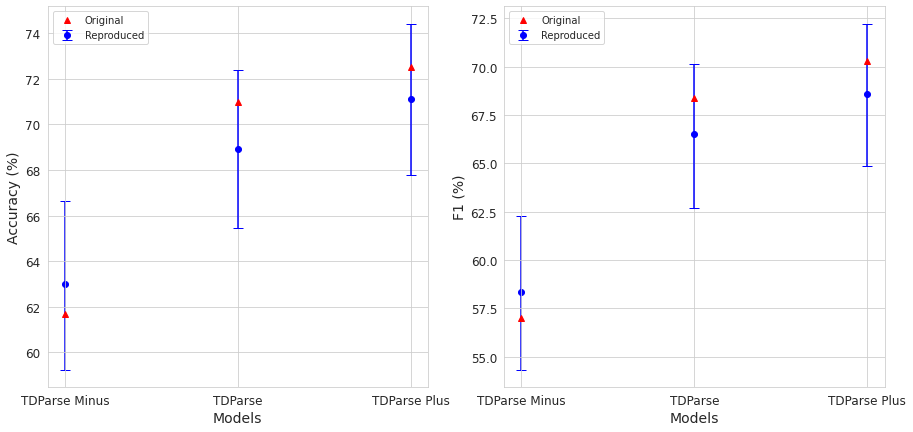

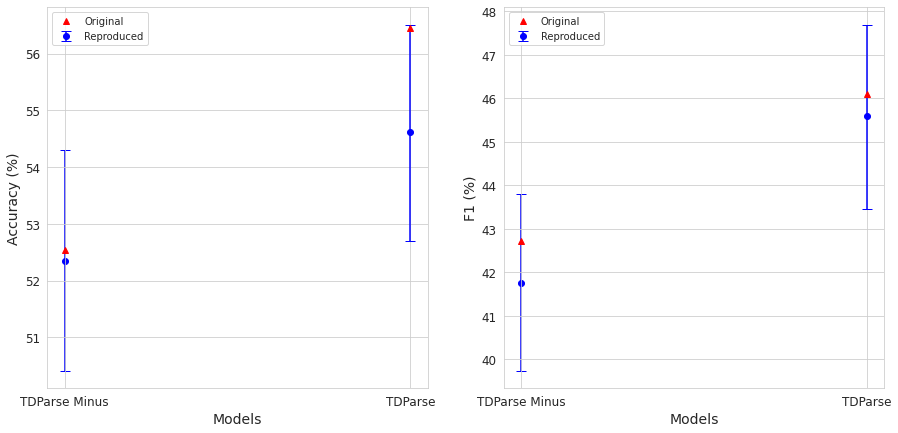

In [10]:
results_alt_scale_f1 = {}

alt_scaler = MinMaxScaler(feature_range=(-1,1))

for dataset in ['Dong', 'Election']:
    train, test = train_test_dataset[dataset]
    vectors = word_vectors[dataset]
    dataset_c = f1_c_values[dataset]
    tdparse_minus = TDParseMinus(vectors, tweebo, scale=alt_scaler,
                                 C=dataset_c['TDParse Minus'])
    tdparse = TDParse(vectors, tweebo, scale=alt_scaler,
                      C=dataset_c['TDParse'])
    tdparse_plus = TDParsePlus(vectors, tweebo, scale=alt_scaler,
                               C=dataset_c['TDParsePlus'],
                               senti_lexicon=all_lexicons)
    models = [tdparse_minus, tdparse, tdparse_plus]
    model_names = ['TDParse Minus', 'TDParse', 'TDParse Plus']
    dataset_preds = []
    for model in models:
        preds = method_predictions(train, test, model, results_dir,
                                   save_name_addon='F1 C value Alt Scale')
        preds = np.expand_dims(np.array(preds), 1)
        dataset_preds.append(preds)
    dataset_preds = np.concatenate(dataset_preds, 1)
    results_alt_scale_f1[dataset] = dataset_preds

    if dataset == 'Election':
        dataset_preds = dataset_preds[:,:2]
        model_names = model_names[:2]

    test_y = np.array(test.sentiment_data())
    bootstrap_acc_preds = thesis_stats.bootstrap(test_y, dataset_preds, 
                                                 accuracy_score, n=10000)
    bootstrap_f1_preds = thesis_stats.bootstrap(test_y, dataset_preds, f1_score, 
                                                average='macro', n=10000)
    boot_preds = [bootstrap_acc_preds, bootstrap_f1_preds]
    metric_funcs = [accuracy_score, f1_score]
    metrics_kwargs = [None, {'average': 'macro'}]
    metric_names = ['Accuracy', 'F1']
    dataset_orginial_scores = orginial_scores[dataset]
    ax = confidence_plots(dataset_preds, boot_preds, test_y, 
                          metric_funcs, metrics_kwargs, metric_names, 
                          model_names, dataset_orginial_scores, dataset, 'TDParse')
    image_fp = str(Path(image_dir, f'TDParse_F1_C_value_alt_scale_{dataset}.pdf').resolve())
    ax.figure.savefig(image_fp, bbox_inches='tight')